# Robustness Analysis for Deep Vertically Federated Learning

Within this notebook, we train an ensemble of “black box” deep neural network in a vertically federated setting construction and ask cognitively motivated questions. Question such as:
- How does the network’s behavior / performance change as a function of an exogenous factor?
    - Network depth
    - Noise applied to different parts of the enesmble model
- How can we modify the training algorithm to increase the network’s robustness?
    - Can we take advantage of the vetically federated setting?

In [1]:
# Importing Required Libraries

# Libraries for Data Handling
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset

# Libraries for Algorithms
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import average_precision_score, accuracy_score
import helper

# Libraries for Data Visulation Tools
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# experiment params:

# n distinct parties 
n_distinct_parties = 5

# dataset dir (must be generated by pre-processor for respective n_distinct_parties)
dataset_dir = f"datasets/pre_processed_adult_{n_distinct_parties}p"

# results dir (where to save the results)
results_dir = f"results/adult_{n_distinct_parties}p"

In [3]:
# Import pre-processed Dataset
test_datframes = []
train_dataframes = []
for i in range(1, n_distinct_parties+1):
    test_datframes.append(pd.read_csv(f"{dataset_dir}/test_data_party_{i}.csv", sep=',', header=0))
    train_dataframes.append(pd.read_csv(f"{dataset_dir}/train_data_party_{i}.csv", sep=',', header=0))

test_y_dataframe = pd.read_csv(f"{dataset_dir}/test_labels.csv", sep=',', header=0)
train_y_dataframe = pd.read_csv(f"{dataset_dir}/train_labels.csv", sep=',', header=0)

# Convert DataFrames to Tensors
test_datasets = []
train_datasets = []
for i in range(n_distinct_parties):
    test_datasets.append(torch.tensor(test_datframes[i].values, dtype=torch.float32))
    train_datasets.append(torch.tensor(train_dataframes[i].values, dtype=torch.float32))

test_y = torch.tensor(test_y_dataframe.values, dtype=torch.float32)
train_y = torch.tensor(train_y_dataframe.values, dtype=torch.float32)

# identify feature->party parition:
party_paritions = [len(i.columns) for i in train_dataframes]

In [4]:
# Create dataset/dataloader for party input (concatonate all parties for clean dataloader)

# Create dataset
train_dataset = TensorDataset(torch.cat(train_datasets, dim=1), train_y)
test_dataset = TensorDataset(torch.cat(test_datasets, dim=1), test_y)

# Create dataloader
train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=128, shuffle=False)

In [5]:
# define models
client_output_embedding_size = 32
client_models = helper.generateClientModels(party_paritions, client_output_embedding_size)

fusion_model = helper.generateFusionModel(client_output_embedding_size * n_distinct_parties)


# define optimizers and loss function
client_optimizers = [optim.Adam(model.parameters(), lr=0.001) for model in client_models]
fusion_optimizer = optim.SGD(fusion_model.parameters(), lr=0.001)
loss_fn = nn.BCELoss()

In [6]:
# %%script true
# Train ensemble model without noise

training_params = {
    "client_models": client_models,
    "fusion_model": fusion_model,
    "party_paritions": party_paritions,
    "train_dataloader": train_dataloader,
    "client_optimizers": client_optimizers,
    "fusion_optimizer": fusion_optimizer,
    "loss_fn": loss_fn,
    "epochs": 10
}

losses, epo, auprc_values = helper.trainEnsemble(**training_params)

Epoch 1 - Loss: 0.47858261331623675, AUPRC: 0.6955545238157004
Epoch 2 - Loss: 0.3976422611112688, AUPRC: 0.7242888278349845
Epoch 3 - Loss: 0.366737277192228, AUPRC: 0.7346124882904568
Epoch 4 - Loss: 0.3513694835790232, AUPRC: 0.7424879958986739
Epoch 5 - Loss: 0.3427719841985142, AUPRC: 0.745815153118589
Epoch 6 - Loss: 0.3385900997501962, AUPRC: 0.7460529434612008
Epoch 7 - Loss: 0.3345854343006424, AUPRC: 0.7501394153552644
Epoch 8 - Loss: 0.330571581116494, AUPRC: 0.7552631656065276
Epoch 9 - Loss: 0.32741816999281154, AUPRC: 0.757898923059505
Epoch 10 - Loss: 0.32611895337993024, AUPRC: 0.7607756334143164


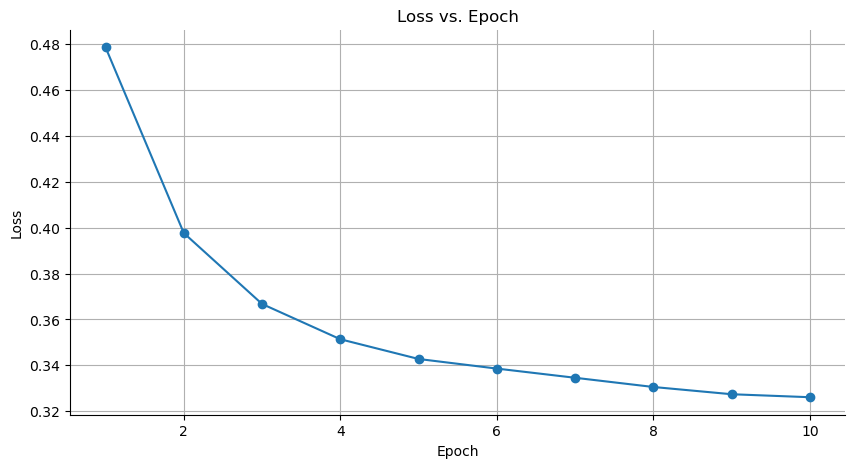

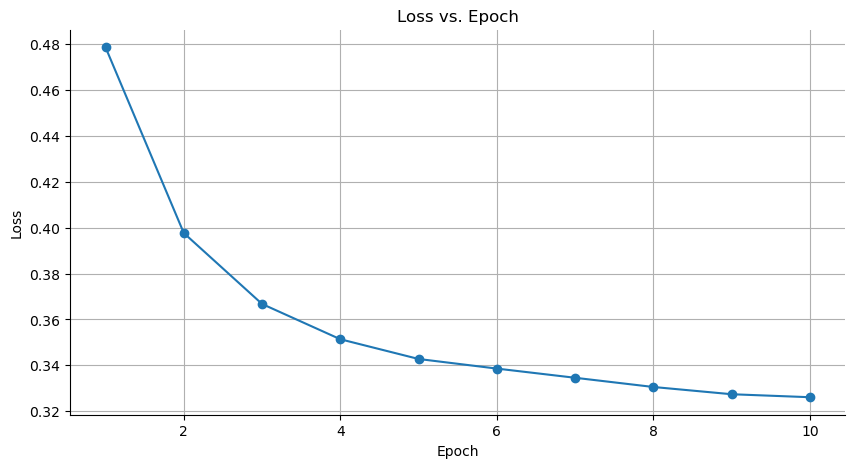

In [8]:
helper.generateLossGraph(losses, epo)